# Installing, Importing and Helper functions



In [106]:
import findiff
from findiff import FinDiff
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from findiff import FinDiff, PDE, BoundaryConditions, Coef
from findiff.diff import Id
import scipy.ndimage
from scipy.sparse.linalg import eigs as find_eigs
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.image as mpimg


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##Helper Functions

In [107]:
def delete(arr: torch.Tensor, ind: int, dim: int) -> torch.Tensor:
    skip = [i for i in range(arr.size(dim)) if i != ind]
    indices = [slice(None) if i != dim else skip for i in range(arr.ndim)]
    return arr.__getitem__(indices)

def insert(arr: torch.Tensor, insert: torch.Tensor, ind: int, dim: int) -> torch.Tensor:
    if ind > 0:
        before_ind = [i for i in range(arr.size(dim)) if i < ind]
        before_indices = [slice(None) if i != dim else before_ind for i in range(arr.ndim)]
        before_arr = arr[before_indices]
        result = torch.cat((before_arr, insert))
    else:
        if insert.dim() < 1:
            insert = torch.tensor([insert])
        result = insert

    if ind < arr.size(dim) -1:
        after_ind = [i for i in range(arr.size(dim)) if i >= ind]
        after_indices = [slice(None) if i != dim else after_ind for i in range(arr.ndim)]
        after_arr = arr[after_indices]
        result = torch.cat((result, after_arr))
    
    return result 

def restricted_evec_problem(A, conditions):
    '''
    return the eigenvectors which satisfy a given condition. 
    
    parameters
    ----------
    A           np.array, A.shape = (n,n)
                the matrix whose restricted eigenvalues we are
                trying to find.
    conditions  np.array, conditions.shape = (m,n+1)
                the set of restrictions our eigenvalues must have.
                for each of the m conditions:
                write the restriction in the following form:
                a_1 v_1 + a_2 v_2 + ... + a_n v_n + c = 0
                then input a line of the conditions matrix:
                [a_1, a_2, ..., a_n, c]
    '''
    n = A.shape[0]
    eigenvectors = []
    eigenvalues = []
    
    # factor out c from the conditions
    
    # our target is the first non-zero entry of the condition
    target = np.where(conditions[0] != 0)[0][0]
    
    # creating the reformed A matrix
    A_1 = np.delete(A, target, axis=0)
    A_1 = np.delete(A_1, target, axis=1)
    # a vector from the target column of the A matrix
    a = np.delete(A[:,target], target)
    # b vector in the form v_target = sum of b_i v_i
    b = np.delete(conditions[0][:-1], target) * -1 / conditions[0][target]
    A_1 += np.outer(a, b)
    
    mini_evals, mini_evecs = np.linalg.eig(A_1)
    
    for i in range(n-1):
        evec = np.insert(mini_evecs[:,i], target, np.sum(b * mini_evecs[:,i]))
        if np.abs(A[target,:] @ evec - mini_evals[i] * np.sum(b * mini_evecs[:,i])) < 1e-9:
            eigenvectors.append(evec)
            eigenvalues.append(mini_evals[i])
            
    return eigenvectors, eigenvalues

#Helper functions
def make_big_d(start, end, step_count):
    step_size = (end - start)/step_count
    return torch.linspace(start - step_size, end+step_size, step_count + 2)

def make_laplace_1d(shape : tuple, dt : float, do_assist = False):
    '''
    This just approximates the laplacian in 1 dimension in matrix form using a stencil matrix
    
    '''
    if not isinstance(shape, tuple):
        shape = (shape[0], shape[0])
    assert shape[0] >=4, "Cannot do less than 4x4 apparently"
    
    L = FinDiff(0,dt,2)
    #I do shape + 2 in order to make the rectangle boundary one larger in each direction
    if do_assist:
        return L.stencil(shape = (np.max(shape)+2, np.max(shape) + 2)).apply_all(np.eye(np.max(shape)+2))
    else:
        return L.stencil(shape = (np.max(shape), np.max(shape))).apply_all(np.eye(np.max(shape)))


def make_laplace_2D(shape : tuple, dt : float, do_assist = False):
    if not isinstance(shape, tuple):
        shape = (shape[0], shape[0])
    assert shape[0] >=4, "Cannot do less than 4x4 apparently"
    
    L = FinDiff(0,dt,2) + FinDiff(1, dt, 2)
    #I do shape + 2 in order to make the rectangle boundary one larger in each direction
    if do_assist:
        return L.stencil(shape = (np.max(shape)+2, np.max(shape) + 2)).apply_all(np.eye(np.max(shape)+2))
    else:
        return L.stencil(shape = (np.max(shape), np.max(shape) )).apply_all(np.eye(np.max(shape)**2))

def make_mask(image_path):
    im = mpimg.imread(image_path)

    # Resize
    im = scipy.ndimage.zoom(im, 0.3125, order=2)

    # Convert to mask
    foo = np.amax(im[:,:,:2],2)<0.5

    # Pad boundary
    mask = np.zeros((foo.shape[0]+2,foo.shape[1]+2),dtype=bool)
    mask[1:-1,1:-1] = foo

    return mask

class SolinDomain():
    def __init__(self, ms : int = 32, xlim : tuple = (0,1), 
                 ylim : tuple = (0,1), image_path = None,
                 mask = None):
        """
        params
        ms : number of basis functions (int)
        image : path
        """

        self.ms = ms
        self.xlim = xlim
        self.ylim = ylim

        if image_path:
            self.mask = make_mask(image_path)
        elif mask:
            self.mask = mask

        
        self.make_laplace_2D()
        self.get_eigenvalues(self.S_h)

    def make_laplace_2D(self):
        """
        Description:
        Make domain from mask of image.
        Where mask of image is 
            np.amax(im[:,:,:2],2)<0.5
        # Pad boundary
        mask = np.zeros((foo.shape[0]+2,foo.shape[1]+2),dtype=bool)
        mask[1:-1,1:-1] = foo

        Params:
        mask: np.amax(im[:,:,:2],2)<0.5, 
        xlim : tuple of (start, stop) for x
        ylim : tuple of (start, stop) for y
        m : number of basis functions to use

        Returns: None
        But stores eigenvalues and eigenfunctions
        """

        # Assert that the mask represents a square area
        assert self.mask.shape[0]==self.mask.shape[1]
        assert self.xlim==self.ylim

        # Composition of the stencil matrix is based on the 9-point rule
        I,J = np.where(self.mask);

        # Values for constructing sparse array
        row = np.array(1);
        col = np.array(1);
        val = np.array(1);

        # Define the operator
        OP = np.array([[1/6,2/3,1/6],[2/3,-10/3,2/3],[1/6,2/3,1/6]])

        for k in range(0,len(I)):
            for di in [-1,0,1]:
                for dj in [-1,0,1]:
                    i = np.where((I==I[k]+di) & (J==J[k]+dj))
                    row = np.append(row,k*np.ones(i[0].shape))
                    col = np.append(col,i[0])
                    val = np.append(val,OP[di+1,dj+1]*np.ones(i[0].shape))

        # Discard placeholders
        row = row[1:]
        col = col[1:]
        val = val[1:]

        # Scale by step size
        h = (self.xlim[1]-self.xlim[0])/(self.mask.shape[1]+1)
        val /= h**2

        # Construct the stencil matrix
        S_h = coo_matrix((val, (row, col)), shape=(len(I), len(I)))
        self.S_h = S_h
        self.h = h

    def get_eigenvalues(self, S_h):
        # Solve eigenvalue problem
        mu,V = eigsh(S_h, k=self.ms, which='LA')

        # Better approximations of the eigenvalues
        self.hlambda = np.flipud(2*mu / (np.sqrt(1 + mu*self.h**2/3) + 1));

        # Address scaling issues
        V = V * 1/self.h;

            # Expand size to match self.mask
        Vsquare = np.zeros((self.mask.shape[0]*self.mask.shape[1],self.ms))
        ind, = np.where(self.mask.flatten())
        for i in range(len(ind)):
            Vsquare[ind[i],:] = V[i,:]

        # Store eigenvectors and self.mask
        self.V = np.fliplr(Vsquare)
        self.x1 = np.linspace(self.xlim[0],self.xlim[1],self.mask.shape[1])
        self.x2 = np.linspace(self.ylim[0],self.ylim[1],self.mask.shape[0])


# Playing around with Solin

The below just sets up a problem to be solved. In this case the problem is solving the PDE given by 

$u''(t) = sin(t) \\
: t \in [0,1]$

And we solve this using a finite difference method, with a step size of $\frac{1}{300}$



In [9]:
'''
Define the test problem below
'''

shape = (300, )
t = np.linspace(0, 10, shape[0])
dt = t[1]-t[0]

ALPHA = 3
OMEGA = 2
LAMBDA = 0

laplace_1d = FinDiff(0,dt,2)

# L = FinDiff(0, dt, 2) - Coef(ALPHA)*FinDiff(0, dt, 1) + Coef(OMEGA**2)*Id()

#The true function
# f = 81*np.sin(9*t)
f = np.sin(t)

#Add some boundary conditions
bc = BoundaryConditions(shape)
bc[0] = 0
# bc[-1] = 0
# bc[1] = FinDiff(0, dt, 1), 0
# bc[-2] = FinDiff(0, dt, 1), 0

#If you dont give it boundary condition at t[-1] it breaks for some reason :S
# bc[-1] = -np.sin(9*t[-1])
bc[-1] = -np.sin(t[-1])
# bc[-2] = FinDiff(0, dt, 1), 0

#Solve the PDE using a solver (although I would have assumed the answer to just be -np.sin(t))
pde = PDE(laplace_1d, f, bc)
#Store the solution in u_true
u_true = pde.solve()

#Find the eigenvectors and eigenvalues of the laplacian
lapl_mat = make_laplace_1d(shape, dt)
lapl_res = lapl_mat[1:,1:]
lam_res, u_res = find_eigs(lapl_res)

# stencil = laplace_2d.stencil(u.shape)
# This here seems useless atm idk
# print(len(stencil.data))

#This gives a the stencil I'm looking for similar to the paper
# print(stencil.apply_all(u)/324)



In [10]:
lapl_mat*(dt**2)

array([[ 2., -5.,  4., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  4., -5.,  2.]])

(300, 300)


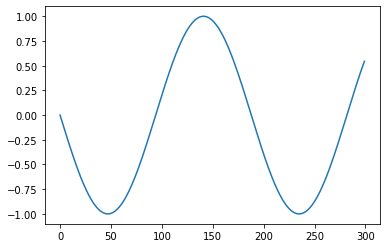

In [11]:
plt.plot(u_true)

print(lapl_mat.shape)

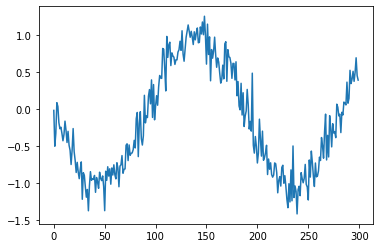

In [12]:
y = u_true + 0.2*np.random.normal(size = shape)
plt.plot(y)

In [13]:
#Choosing samples
sample_indices = np.random.choice(np.arange(0,shape[0]), size = 20)
# sample_indices = np.arange(50)
train_x = torch.Tensor(t[sample_indices])
# True function is -sin(x) with Gaussian noise? I wouldve assumed
y_train = y
train_y = torch.Tensor(y_train[sample_indices])

# Fitting a standard matern gp

And also adding some helper functions




In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel = None, has_noise = True, is_zero_mean = False):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() if not is_zero_mean else gpytorch.means.ZeroMean()
        if not kernel:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        else:
            self.covar_module = kernel
            
        if not has_noise:
            # Assume: likelihood noise constraint was defined so that 1e-4 is within range.
            self.likelihood.noise = 1e-4  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
            self.likelihood.noise_covar.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [15]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

def plot(observed_pred, train_x, train_y, test_x=torch.linspace(0, 10, 300), true_func = None, mean_adjustment = 0):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(9, 9))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy() + mean_adjustment, 'b')
        
        if true_func is not None:
            # Plot true function if exists
            ax.plot(test_x.numpy(), true_func, 'green')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy() + mean_adjustment, upper.numpy() + mean_adjustment, alpha=0.5)
        ax.grid(True)
        ax.set_ylim([-4, 4])
        legend = ['Observed Data', 'Mean', 'True function', 'Confidence']
        ax.legend(legend if true_func is not None else legend[~2])
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, train_x, train_y, likelihood, training_iter=training_iter, verbose = True):
   # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        
        
        
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


# Trying to implement Boundary Complacent GPs

This includes 2 classes:


1.   Boundary Class - Helps create the appropriate laplacian for different kinds of boundary conditions
2.   Custom Kernel that takes boundary objects as arguments and fits according to Solin paper

Alert! Doesnt actually work very well



In [101]:
#Simple first order boundary approx
class Boundary():
    def __init__(self, kind : str = 'neumann', indices : list = [(0, slice(None)), (2, slice(None))],
        values : torch.Tensor = torch.Tensor([-1,1]), deriv : float = 0, step_size : float = 0.01,
        constants = None):
        '''
        Creates a neumann or dirichlet boundary condition object

        Args:
        kind: Kind/type of boundary condition (either neumman or dirichlet).

        indexes: List of indices in which the relation holds. For dirichlet this is typically integer indices, 
        for neumann typically slice indices. 

        values: List of floats such that torch.dot(indices, values) / 2h == deriv. See example for further clarity.

        deriv: Float such that np.dot(indices, values) / 2h == deriv. See example for further clarity.

        Returns:
        This is a description of what is returned.

        Example:
        Function f : (x,y) -> z and Neumann condition df/dx(0,y) = 0.
        Domain is [-0.1 : 1.0 : 101]^2 i.e [-0.01, 0.00, 0.01, 0.02, ...] ^ 2
        (So in the finite difference world we have h = 0.01)
        The corresponding indexes should be [[0, slice(None)], [2, slice(None)]]
        The corresponding values should be [-1,1]
        The corresponding offset should be 0
        This indicates that (f[.01,y] - f[-0.01,y])/2h = 0


        Raises:
        KeyError: Raises an exception.
        '''
        self.kind = kind
        self.indices = indices

        self._values = values
        self.step_size = step_size
        if constants is None:
            self.constants = -2 * step_size * deriv
        else:
            self.constants = constants
        
        #Right_vec is used for solving the particular solution
        self.right_vec = None
        self.mean_adjustment = 0

    #For neumann only   
    def restrict_laplacian(self, l_mat : torch.Tensor, domain : torch.Tensor, dirichlet = False, right_vec = None):
        """
        Takes Laplacian Matrix L and incorporates constraints
        
        
        Let c be number of constraints
        
        Does so by creating matrix B (n-c) x (n-c) from the corresponding columns of matrix L
        """
        
        
        n = domain.flatten().shape[0]
        
        index_matrix = torch.arange(n).view(domain.shape)
        
        left_ind = index_matrix[self.indices[0]]
        
        right_ind = index_matrix[self.indices[1]]

        if dirichlet:
            #reset the matrix to only be one diagonal entry for dirichlet
            row_selector = [x for x in range(n) if x not in left_ind and x not in right_ind]
            l_res = l_mat[row_selector][:, row_selector]
            assert (l_res == l_mat[1:-1,1:-1]).all()
            # return l_mat[1:-1,1:-1]
            #Find the correct mean adjustment whilst at it
            self.adjust_right_vec(l_mat, domain, dirichlet, right_vec)
            return l_res

        #Correct value indices now we know domain
        self.values = torch.zeros_like(domain).flatten()

        self.values[left_ind] = self._values[0] 
        self.values[right_ind] = self._values[1]
                        
        #Find the relevant columns in the laplace matrix
        b_mat = l_mat[:, left_ind]
        
        
        #Multiply these columns by the vector of values in the constraint and deriv * 2h
        #Note, I have not deleted any row yet
        b_mat = b_mat * self._values[1]

        l_mat[:, right_ind] += b_mat

        #Delete the rows corresponding to the columns we extracted
        row_selector = [x for x in range(n) if x not in left_ind]
                
        l_res = l_mat[row_selector][:, row_selector]

        assert l_res.shape[0] == l_res.shape[1], l_res.shape

        self.adjust_right_vec(l_res, domain, dirichlet, right_vec)

        return l_res
    
    def fill_u(self, u_res, domain, l_mat = None, dirichlet = False, mean_adjustment = None):

        foo = torch.zeros_like(u_res)
        bar = torch.zeros(u_res.shape[0]).view(1,-1)
        n = domain.flatten().shape[0]
        index_matrix = torch.arange(n).view(domain.shape)
        left_ind = index_matrix[self.indices[0]]
        right_ind = index_matrix[self.indices[1]]

        u_filled = torch.concat((foo,bar))
        assert u_filled.shape[0] == foo.shape[0] + 1

        #Dirichlet
        if dirichlet:
            u_filled = torch.cat((u_filled, bar))
            #Need to fill in both left and right indices
            row_selector = [x for x in range(u_filled.shape[0]) if x not in left_ind and x not in right_ind]
            u_filled[left_ind] = 0
            u_filled[right_ind] = 0
            u_filled[row_selector] = u_res.clone()
            return u_filled
        
        #Neumann
        row_selector = [x for x in range(u_filled.shape[0]) if x not in left_ind]
        u_filled[row_selector] = u_res

        u_filled[self.indices[0]] = ((self.values[1:].view(-1,1) * u_filled[self.indices[1:]].view(1,-1)).sum(axis=0)).view(1,-1)

        assert (u_filled[0] - u_filled[2] == 0).all()
        print('mean adjustment is ......')
        print(mean_adjustment)
        print('nothing?')
        if mean_adjustment is not None: 
            mean_adjustment = insert(mean_adjustment, mean_adjustment[left_ind], left_ind)
            #Need to do right_ind - 1 because vector will be short and needs to be extended
            mean_adjustment = insert(mean_adjustment, mean_adjustment[right_ind - 1], right_ind - 1)
            self.mean_adjustment = mean_adjustment
            
            u_filled += mean_adjustment.view(1,-1)
            print('hey hey leverpastej')
        return u_filled

    def adjust_right_vec(self, l_mat, domain, dirichlet = False, right_vec = None):
        """
        Remember neumann needs to be solved on l_res, whereas
        dirichlet needs to be solved on l_mat
        """
        
        
        n = domain.flatten().shape[0]
        index_matrix = torch.arange(n).view(domain.shape)
        
        
        if right_vec is None:
            right_vec = torch.zeros(l_mat.shape[0])
        
        if dirichlet:
            #Find the relevant columns in the laplace matrix
            all_indices = []
            for i in range(len(self.indices)):
                indices = index_matrix[self.indices[i]]
                b = l_mat[:, indices]
                right_vec -= b * self.constants[i]
                all_indices.extend([indices.numpy()])
            
            row_selector = [i for i in range(n) if i not in all_indices]
            right_vec = right_vec[row_selector]
            
            #Alternative method
            right_vec2 = torch.zeros(l_mat.shape[0])
            l_new = l_mat.clone()

            for i in range(len(self.indices)):
                indices = index_matrix[self.indices[i]]
                right_vec2[indices] = self.constants[i]
                l_new[indices] = 0
                l_new[indices, indices] = 1
            sol = torch.linalg.solve(l_new.float(), right_vec2)
            self.mean_adjustment = sol

        
        #Neumann needs to be adjusted for general case data struct
        else:

            left_ind = index_matrix[self.indices[0]]
            right_ind = index_matrix[self.indices[1]]
            b = l_mat[:, right_ind]
            right_vec -= b* self.constants
        
        self.right_vec = right_vec.type(torch.DoubleTensor)


    
        
        

        

    
        

In [104]:
class BCKernel(gpytorch.kernels.Kernel):
    def __init__(self, domain, likelihood, dirichlet : list = None, neumann : list = None,
                 nu_prior = None, nu_constraint = None, big_domain = None,
                 **kwargs):
        
        """
        args:
        dirichlet/neumann are lists of Boundary objects
        """
        super().__init__(**kwargs)
        
        #Initialise for later
        self.mean_adjustment = None


        self.likelihood = likelihood
        self.domain = domain if torch.is_tensor(domain) else torch.as_tensor(domain)
        
        if big_domain is None:
            raise NotImplemented("currently need big_domain)")
        self.big_domain = big_domain
        
        #Only 2 dimension at the moment
        self.dimension = 1 if len(domain.shape) == 1 else domain.shape[1]
        self.nu = torch.tensor(3.5, requires_grad = True)
        
        # self._register_nu(nu_constraint, nu_prior)
        
        # Hard coded for now!! TODO: Make more general for more dimensions
        dt = domain[1] - domain[0]
        self.h = dt

        lapl_mat = make_laplace_1d(self.big_domain.shape, dt.item())
        lapl_mat[0] = lapl_mat[1]
        lapl_mat[-1] = lapl_mat[-2]
        self.L_full = -1 * lapl_mat

        if neumann is not None:
            right_vec = None
            for n in neumann:
                self.L = n.restrict_laplacian(torch.tensor(self.L_full), self.big_domain, right_vec = right_vec)
                right_vec = n.right_vec
        if dirichlet is not None:
            right_vec = None
            for d in dirichlet:
                #Here we do not need the extended laplacian matrix
                self.L_full = self.L_full[1:-1,1:-1]
                self.L = d.restrict_laplacian(torch.tensor(self.L_full), self.domain, dirichlet = True, right_vec = right_vec)
                right_vec = d.right_vec
                adjustment2 = d.mean_adjustment
            
            self.mean_adjustment = torch.linalg.solve(torch.as_tensor(self.L), torch.as_tensor(right_vec))
            
            if adjustment2 is not None:
                self.mean_adjustment = adjustment2
                
        # Get the eigenvalues and eigenvectors of the restricted domain

        # assert (self.L_tru == self.L).all()
        self.lam_full, self.u_res = torch.linalg.eig(torch.tensor(self.L))

        #Scaling issues addressed. I'm not sure what I'm doing but YOLO
        self.u_res/= self.h

        global debug_u_res
        debug_u_res = self.u_res
        
        #Correct eigenvalues from approximation
        # self.lam_full = torch.flipud(2*self.lam_full / (np.sqrt(1 + self.lam_full*self.h**2/3) + 1));

        if neumann is not None: 
            for n in neumann:
                self.u_full = n.fill_u(self.u_res, self.big_domain)
        else:
            self.u_full = self.u_res
                
        if dirichlet is not None:
            for d in dirichlet:
                print('hey hey leverpastej')
                self.u_full = d.fill_u(self.u_res, self.domain, self.L, dirichlet = True, mean_adjustment = self.mean_adjustment)
                adjustment = d.mean_adjustment
            if adjustment2 is None:
                self.mean_adjustment = adjustment

        # assert False        
        global debug_restricted_L
        debug_lam_full = self.lam_full
        debug_restricted_L = self.L


        # self.u_full = self.u_tru/self.h

        global eigenvectors
        eigenvectors = self.u_full
        global eigenvalues
        eigenvalues = self.lam_full

        self.big_u_1 = None
        self.big_u_2 = None

        global L_full
        L_full = self.L_full
    
    # the BCkernel is stationary and has lengthscale
    is_stationary = True
    has_lengthscale = True

    
    def forward(self, x1, x2, **params):

        spec_eigvals = self._compute_spectral(self.lam_full, **params)
        
        '''
        The below code just makes a vector of indices that correspond 
        to the correct eigenvectors from the domain
                            START [Unreasonable code]
        ---------------------------------------------------------------
        '''

        ind_x1 = []
        for xi in x1:
            ix_x1 = torch.where(torch.abs(self.domain - xi) < 1e-6)
            ind_x1.append(ix_x1[0])
            if len(ix_x1[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x2 = []
        for xi in x2:
            #TODO: Add optionality of adding indices instead, and change hardcoding to perhaps step_size/2 for 1e-6
            ix_x2 = torch.where(torch.abs(self.domain - xi) < 1e-6)
            ind_x2.append(ix_x2[0])
            if len(ix_x2[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x1 = torch.concat(ind_x1)
        ind_x2 = torch.concat(ind_x2)
        
        
        '''
                                END [Unreasonable code]
        ---------------------------------------------------------------
        '''
        
        #Use index in order to calculate \Phi.T \Lambda (diagonal eigenvalues) \Phi (eigenvector)
        #See equation (11) in KnowYourBoundaries.pdf

        big_lambda = spec_eigvals*torch.eye(spec_eigvals.flatten().shape[0])

        
        self.big_u_1 = self.u_full[ind_x1].clone().type(torch.complex128)
        self.big_u_2 = self.u_full[ind_x2].clone().type(torch.complex128)
        
        covar_matrix = ((self.big_u_1.conj() @ big_lambda.type(torch.complex128) @ self.big_u_2.T)).float()

        #TODO: Incorporate dirichlet boundary
        return covar_matrix
    
    def _compute_spectral(self, eigvals, **params):
        
        '''
        See equation (11) in KnowYourBoundaries.pdf
        '''
        
        d = self.dimension if torch.is_tensor(self.dimension) else torch.as_tensor(self.dimension)
        l = self.lengthscale
        v = self.nu


        log_gamma_term = torch.lgamma(v + d/2) - torch.lgamma(v)

        # const_term = 2**d * torch.pi ** (d/2) * (2*v)**v / l**(2*v)
        log_const_term = d*torch.log(torch.tensor([2])) + d/2 * torch.log(torch.tensor(torch.pi)) +  v * torch.log(2*v)  -  2*v*torch.log(l)
        
        # We take abs eigvals because the eigenvalues are meant to be positive if we had done the 
        # Negative laplacian instead of the laplacian as the matrix
        foo = (2*v/torch.pow(l,2) + torch.abs(eigvals))

        spectral = torch.exp(log_gamma_term + log_const_term ) * torch.pow((foo), -(2*v+d)/2)
        return spectral
    

        

#Train models on datapoints and fit

In [105]:
from numpy.core.numeric import indices

train_y_foo = train_x
domain = torch.linspace(0, 10, shape[0])
big_domain = make_big_d(0,10,shape[0])
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
neumann_test = Boundary('neumann', [[0], [2]])
dirichlet_test = Boundary('dirichlet', [0, shape[0] -1], constants = [0, -torch.sin(torch.tensor(t[-1]))])


bc_k = BCKernel(domain = domain, dirichlet = [dirichlet_test,], likelihood = likelihood2, big_domain = big_domain)
bc_kernel = gpytorch.kernels.ScaleKernel(bc_k)
# bc_kernel = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain))
model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_kernel, is_zero_mean = True)

adjustment = bc_k.mean_adjustment
# model2.covar_module = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain))
# model2.covar_module = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, likelihood = likelihood2, big_domain = big_domain))
# model2.covar_module = BCKernel(domain = domain, likelihood = likelihood2, big_domain = big_domain)

print("-----------------------INITIAL PARAMS-------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

print("--------------------------------------------------------------")
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)

print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

hey hey leverpastej
-----------------------INITIAL PARAMS-------------------------
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
--------------------------------------------------------------
Iter 1/50 - Loss: 1.771   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.703   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.635   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.566   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 1.497   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 1.429   lengthscale: 0.974   noise: 0.473
Iter 7/50 - Loss: 1.361   lengthscale: 1.037   noise: 0.436
Iter 8/50 - Loss: 1.293   lengthscale: 1.102   noise: 0.402
Iter 9/50 - Loss: 1.226   lengthscale: 1.169   noise: 0.369
Iter 10/50 - Loss: 1.160   lengthscale: 1.237   noise: 0.338
Iter 11/50 - Loss: 1.094   lengthscale: 

/tmp/ipykernel_5227/1289780192.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.lam_full, self.u_res = torch.linalg.eig(torch.tensor(self.L))


In [62]:
%debug

> /tmp/ipykernel_5227/2575678535.py(177)adjust_right_vec()
    175                 right_vec[indices] = self.constants[i]
    176                 l_new[indices] = 0
--> 177                 l_new[indices][:,indices] = 1
    178             sol = torch.linalg.solve(l_new, right_vec)
    179             self.mean_adjustment = sol



ipdb>  l_new.shape


torch.Size([300, 300])


ipdb>  indices.shape


torch.Size([])


ipdb>  indices


tensor(0)


ipdb>  exit


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, is_zero_mean = True)
model.train()
likelihood.train()
train(model, train_x, train_y, likelihood, verbose = True)
model.eval()
likelihood.eval()
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 300)
    observed_pred = likelihood(model(test_x))
print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

# Plot results


1.   Naive Matern GP
2.   Boundary incorporated Matern GP

You should expect to see points around the boundary to be better captured by second plot



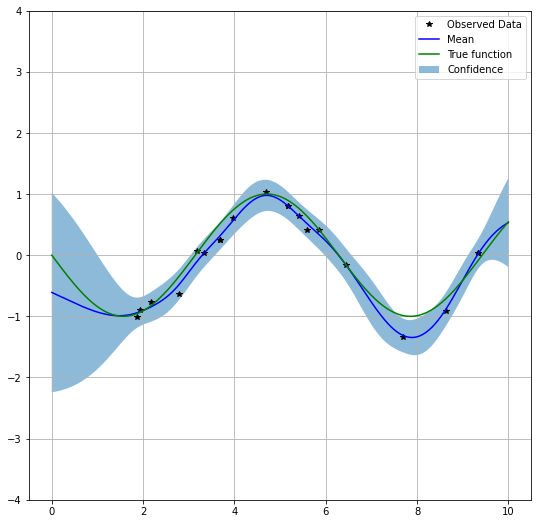

In [20]:
plot(observed_pred, train_x, train_y, true_func = u_true)

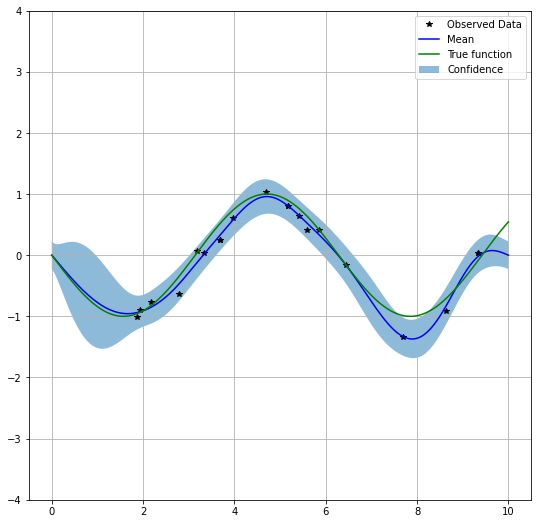

In [93]:
model2.eval()
likelihood2.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 10, 300)
    observed_pred2 = likelihood2(model2(test_x))
observed_pred2 = predict(model2, likelihood2, test_x)
plot(observed_pred2, train_x, train_y, true_func = u_true, mean_adjustment = 0)

#Benchmarking

#Debug Playground

 A = 5 x 5
 [1 0 0 0 0]          u[0]
 [1 -2 1 0 0]         u[1]
 [0 1 -2 1 0]    @    u[2]     =     λ u
 [0 0 1 -2 1]         u[3]
 [0 0 0 0 1]          u[4]


We have found u, λ such that for:
B = 3 x 3
[-2 1 0]             u[1]
[1 -2 1]      @      u[2]   = λ u
[0 1 -2]             u[3]

Now, we want to find u such that when u[0] = a, it is a point on the eigenvector of C:

C = 4 x 4
[1 0  0 0]             u[0] = a                   a
[1 -2 1 0]             u[1]                       λu[1] + a
[0 1 -2 1]      @      u[2]              --->     λu[2]
[0 0 1 -2]             u[3]                       λu[3]



[1 0 0 0 0]           u[0]
 [1 -2 1 0 0]         u[1]
 [0 1 -2 1 0]    @    u[2]     =     λ u
 [0 0 1 -2 1]         u[3]
 [0 0 0 0 1]          u[4]

u[0] - 2u[1] + u[2] = λ u[0]
u[1] - 2u[2] + u[3] = λ u[1]
...


 B = A[1:,1:]
 B = 2 x 2

Eigenvectors of B:
 [u2, u3], [k2, k3]

Proposed eigenvectors of A that satisfy u1 = 3
 u_new : [u1 = 3, u2, u3], k_new : [k1 = 3, k2, k3]

Also needs to satisfy
A @ u_new = lambda * u_new 

for eigenvecs_b of B:
    let u_new = [0 , eigenvecs[b]]
    if A @ u_new = lambda * u_new:
        append u_new as correct eigenvec


A b = lambda b 
(A - lambda I) b= 0

(A - lambda I)^-1 0 = b

torch.Size([300, 298])
torch.ComplexDoubleTensor
tensor(True)
tensor(False)


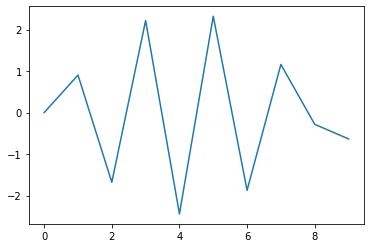

In [ ]:
print(eigenvectors.shape)
print(eigenvectors.type())

plt.plot(torch.real(eigenvectors[:10, 0]))
a = 20
# print(eigenvectors[0,a])
# print((eigenvectors[0,a] - eigenvectors[2,a] == 0).all())
# for i in range(a):
#     print(eigenvectors[0,a])
#     print(eigenvectors[-1,a])



print((torch.real(eigenvectors[0,:]) == 0).all())
print((torch.real(eigenvectors[-1,:]) == np.sin(t[-1])).all())

In [90]:
print(bc_k.mean_adjustment)

tensor([-2.0528e-04,  1.6149e-03,  3.4350e-03,  5.2552e-03,  7.0754e-03,
         8.8955e-03,  1.0716e-02,  1.2536e-02,  1.4356e-02,  1.6176e-02,
         1.7996e-02,  1.9816e-02,  2.1637e-02,  2.3457e-02,  2.5277e-02,
         2.7097e-02,  2.8917e-02,  3.0737e-02,  3.2558e-02,  3.4378e-02,
         3.6198e-02,  3.8018e-02,  3.9838e-02,  4.1658e-02,  4.3479e-02,
         4.5299e-02,  4.7119e-02,  4.8939e-02,  5.0759e-02,  5.2579e-02,
         5.4400e-02,  5.6220e-02,  5.8040e-02,  5.9860e-02,  6.1680e-02,
         6.3500e-02,  6.5321e-02,  6.7141e-02,  6.8961e-02,  7.0781e-02,
         7.2601e-02,  7.4421e-02,  7.6242e-02,  7.8062e-02,  7.9882e-02,
         8.1702e-02,  8.3522e-02,  8.5342e-02,  8.7162e-02,  8.8983e-02,
         9.0803e-02,  9.2623e-02,  9.4443e-02,  9.6263e-02,  9.8083e-02,
         9.9904e-02,  1.0172e-01,  1.0354e-01,  1.0536e-01,  1.0718e-01,
         1.0900e-01,  1.1082e-01,  1.1264e-01,  1.1446e-01,  1.1629e-01,
         1.1811e-01,  1.1993e-01,  1.2175e-01,  1.2

In [42]:
##2 different solutions to the same problem

right_test = dirichlet_test.right_vec
print(dirichlet_test.right_vec.shape)
L_full = torch.as_tensor(L_full)
print(L_full.shape)
print((L_full @ adjustment)[-3:])
print(right_test[-4:])
L_full[0] = 0; L_full[0,0] = 1
L_full[-1] = 0; L_full[-1,-1] = 1;
print(L_full[-4:,-4:])
b = torch.zeros(L_full.shape[1])
col = L_full[:, -1]
constant = -torch.sin(torch.tensor(t[-1])) 
b -= col * constant
L_res = L_full[:-1,:-1]
print(L_res[-4:,-4:])
print(b)
adjust = torch.linalg.solve(L_res.float(), b[:-1])
print(adjust)

c = torch.zeros_like(b)
c[-1] = constant
adjust2 = torch.linalg.solve(L_full.float(), c)
print(adjust2)

print(adjust.shape)
print(adjust2.shape)

torch.Size([300])
torch.Size([300, 300])
tensor([  0.0000, 486.3604,  -0.5440], dtype=torch.float64)
tensor([   0.0000,    0.0000,  486.3604, -972.7207], dtype=torch.float64)
tensor([[ 1.7880e+03, -8.9401e+02, -0.0000e+00, -0.0000e+00],
        [-8.9401e+02,  1.7880e+03, -8.9401e+02, -0.0000e+00],
        [-0.0000e+00, -8.9401e+02,  1.7880e+03, -8.9401e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
tensor([[1788.0202, -894.0101,   -0.0000,   -0.0000],
        [-894.0101, 1788.0202, -894.0101,   -0.0000],
        [  -0.0000, -894.0101, 1788.0202, -894.0101],
        [  -0.0000,   -0.0000, -894.0101, 1788.0202]], dtype=torch.float64)
tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000

In [ ]:
#Simple first order boundary approx
class Boundary():
    def __init__(self, kind : str = 'neumann', indices : list = [(0, slice(None)), (2, slice(None))],
        values : torch.Tensor = torch.Tensor([-1,1]), deriv : float = 0, step_size : float = 0.01):
        '''
        Creates a neumann or dirichlet boundary condition object

        Args:
        kind: Kind/type of boundary condition (either neumman or dirichlet).

        indexes: List of indices in which the relation holds. For dirichlet this is typically integer indices, 
        for neumann typically slice indices. 

        values: List of floats such that torch.dot(indices, values) / 2h == deriv. See example for further clarity.

        deriv: Float such that np.dot(indices, values) / 2h == deriv. See example for further clarity.

        Returns:
        This is a description of what is returned.

        Example:
        Function f : (x,y) -> z and Neumann condition df/dx(0,y) = 0.
        Domain is [-0.1 : 1.0 : 101]^2 i.e [-0.01, 0.00, 0.01, 0.02, ...] ^ 2
        (So in the finite difference world we have h = 0.01)
        The corresponding indexes should be [[0, slice(None)], [2, slice(None)]]
        The corresponding values should be [-1,1]
        The corresponding offset should be 0
        This indicates that (f[.01,y] - f[-0.01,y])/2h = 0


        Raises:
        KeyError: Raises an exception.
        '''
        self.kind = kind
        self.indices = indices

        self._values = values
        self.deriv = deriv
        self.step_size = step_size

    #For neumann only   
    def restrict_laplacian(self, l_mat : torch.Tensor, domain : torch.Tensor, dirichlet = False):
        """
        Takes Laplacian Matrix L and incorporates constraints
        
        
        Let c be number of constraints
        
        Does so by creating matrix B (n-c) x (n-c) from the corresponding columns of matrix L
        """
        
        
        n = domain.flatten().shape[0]
        
        index_matrix = torch.arange(n).view(domain.shape)
        
        left_ind = index_matrix[self.indices[0]]
        
        right_ind = index_matrix[self.indices[1]]


        if dirichlet:
            #reset the matrix to only be one diagonal entry for dirichlet
            l_mat[left_ind] = 0
            l_mat[right_ind] = 0
            l_mat[left_ind, left_ind] = 1
            l_mat[right_ind, right_ind] = 1
            # assert (l_mat[[row_selector][:,row_selector]] == l_mat[1:-1,1:-1]).all()
            # return l_mat[1:-1,1:-1]

            self.constant = torch.sum(torch.tensor(self._values))
            self._values = [-1] + (len(self.indices)-1) * [1]
        
        #Correct value indices now we know domain
        self.values = torch.zeros_like(domain).flatten()
        foo = torch.ones_like(domain).flatten()

        self.values[left_ind] = self._values[0] * foo[left_ind]
        self.values[right_ind] = self._values[1] * foo[right_ind]

        if dirichlet:
            return l_mat

                        
        #Find the relevant columns in the laplace matrix
        b_mat = l_mat[:, left_ind]
        
        
        #Multiply these columns by the vector of values in the constraint and deriv * 2h
        #Note, I have not deleted any row yet
        b_mat = b_mat * self._values[1]

        l_mat[:, right_ind] += b_mat

        #Delete the rows corresponding to the columns we extracted
        row_selector = [x for x in range(n) if x not in left_ind]
                
        l_res = l_mat[row_selector][:, row_selector]

        #For now
        # l_res = l_res[:-1,:-1]
        
        #Make some assertion idk
        assert l_res.shape[0] == l_res.shape[1], l_res.shape

        answer = l_res


        """
        Returns an (n-1)x(n-1) that incorporates the constant term in a hacky manner
        
        """
        return answer
    
    #For neumann only
    def fill_u(self, u_res, l_mat = None, dirichlet = False):

        foo = torch.zeros_like(u_res)
        bar = torch.zeros(u_res.shape[0]).view(1,-1)
        n = domain.flatten().shape[0]
        index_matrix = torch.arange(n).view(domain.shape)
        left_ind = index_matrix[self.indices[0]]
        right_ind = index_matrix[self.indices[1]]
        

        u_filled = torch.concat((foo,bar))
        assert u_filled.shape[0] == foo.shape[0] + 1
        
        row_selector = [x for x in range(u_filled.shape[0]) if x not in left_ind]
        u_filled[row_selector] = u_res

        u_filled[self.indices[0]] = ((self.values[1:].view(-1,1) * u_filled[self.indices[1:]].view(1,-1)).sum(axis=0)).view(1,-1)
        

        if not dirichlet:
            self.constant = - 2 * self.step_size * self.deriv
       
        denom = u_filled[self.indices[0]]

        final_constant = self.constant + ((self.values[1:].view(-1,1) * u_filled[self.indices[1:]].view(1,-1)).sum(axis=0)).view(1,-1)

        u_filled *= final_constant / denom
        
        
        assert (u_filled[self.indices[0]] - u_filled[self.indices[1]] == self.constant).all()
        return u_filled

    def fill_u2(self, u_res, lam_res, domain, l_mat_full, dirichlet = False):
        A = l_mat_full
        conditions = torch.tensor(self.get_constraints(domain.numpy()))

        target = torch.where(conditions[0] != 0)[0][0]
        mini_evecs = u_res.clone()
        mini_evals = lam_res.clone()
        eigvecs = []
        eigvals = []
        b = delete(conditions[0], target, 0) * -1 / conditions[0][target]

        if dirichlet:
            A = A.type(torch.complex128)
            for i in range(mini_evecs.shape[1]):
                for j, ind in enumerate(self.indices):
                    evec = insert(mini_evecs[:,i], torch.tensor([self._values[j]]), ind, 0)
               
        else:
            for i in range(mini_evecs.shape[1]):
                evec = insert(mini_evecs[:,i], torch.sum(b* mini_evecs[:,i]), target, 0)
                # if torch.abs(A[target,:] @ evec - mini_evals[i] * torch.sum(b * mini_evecs[:,i])) < 1e-9:
                eigvecs.append(evec)
                eigvals.append(torch.tensor([mini_evals[i]]))
                # assert evec.type() == torch.complex128
        eigvecs = torch.cat(eigvecs, axis = 1)
        eigvals = torch.cat(eigvals)

        return eigvecs, eigvals

    def get_constraints(self, domain):
        n = domain.flatten().shape[0]
        
        index_matrix = np.arange(n).reshape(domain.shape)
        left_ind = index_matrix[self.indices[0]]
        right_ind = index_matrix[self.indices[1]]

        constraints = np.zeros(n)
        constraints[left_ind] = self._values[0]
        constraints[right_ind] = self._values[1]

        constraints = constraints.reshape(1,-1)
        return constraints
    
        

In [ ]:
a = torch.rand((4,1))
b = torch.rand((4,1))
c = torch.cat((a,b), axis = 1)
c.shape

#Normal vector

In [ ]:
import numpy
import dolfin
from dolfin import *


def mesh_to_boundary(v, b_mesh):
    """
    Returns a the boundary representation of the CG-1 function v
    """
    # Extract the underlying volume and boundary meshes
    mesh = v.function_space().mesh()

    # We use a Dof->Vertex mapping to create a global
    # array with all DOF values ordered by mesh vertices
    DofToVert = dolfin.dof_to_vertex_map(v.function_space())
    VGlobal = numpy.zeros(v.vector().size())

    vec = v.vector().get_local()
    for i in range(len(vec)):
        Vert = dolfin.MeshEntity(mesh, 0, DofToVert[i])
        globalIndex = Vert.global_index()
        VGlobal[globalIndex] = vec[i]
    VGlobal = SyncSum(VGlobal)

    # Use the inverse mapping to se the DOF values of a boundary
    # function
    surface_space = dolfin.FunctionSpace(b_mesh, "CG", 1)
    surface_function = dolfin.Function(surface_space)
    mapa = b_mesh.entity_map(0)
    DofToVert = dolfin.dof_to_vertex_map(dolfin.FunctionSpace(b_mesh, "CG", 1))

    LocValues = surface_function.vector().get_local()
    for i in range(len(LocValues)):
        VolVert = dolfin.MeshEntity(mesh, 0, mapa[int(DofToVert[i])])
        GlobalIndex = VolVert.global_index()
        LocValues[i] = VGlobal[GlobalIndex]

    surface_function.vector().set_local(LocValues)
    surface_function.vector().apply('')
    return surface_function

def vector_mesh_to_boundary(func, b_mesh):
    v_split = func.split(deepcopy=True)
    v_b = []
    for v in v_split:
        v_b.append(mesh_to_boundary(v, b_mesh))
    Vb = dolfin.VectorFunctionSpace(b_mesh, "CG", 1)
    vb_out = dolfin.Function(Vb)
    scalar_to_vec = dolfin.FunctionAssigner(Vb, [v.function_space() for
                                                  v in v_b])
    scalar_to_vec.assign(vb_out, v_b)
    return vb_out


def SyncSum(vec):
    """ Returns sum of vec over all mpi processes.
    Each vec vector must have the same dimension for each MPI process """

    comm = dolfin.MPI.comm_world
    NormalsAllProcs = numpy.zeros(comm.Get_size() * len(vec), dtype=vec.dtype)
    comm.Allgather(vec, NormalsAllProcs)

    out = numpy.zeros(len(vec))
    for j in range(comm.Get_size()):
        out += NormalsAllProcs[len(vec) * j:len(vec) * (j + 1)]
    return out

def boundary_to_mesh(f, mesh):
    b_mesh = f.function_space().mesh()
    SpaceV = dolfin.FunctionSpace(mesh, "CG", 1)
    SpaceB = dolfin.FunctionSpace(b_mesh, "CG", 1)

    F = dolfin.Function(SpaceV)
    GValues = numpy.zeros(F.vector().size())

    map = b_mesh.entity_map(0)  # Vertex map from boundary mesh to parent mesh
    d2v = dolfin.dof_to_vertex_map(SpaceB)
    v2d = dolfin.vertex_to_dof_map(SpaceV)

    dof = SpaceV.dofmap()
    imin, imax = dof.ownership_range()

    for i in range(f.vector().local_size()):
        GVertID = dolfin.Vertex(b_mesh, d2v[i]).index()  # Local Vertex ID for given dof on boundary mesh
        PVertID = map[GVertID]  # Local Vertex ID of parent mesh
        PDof = v2d[PVertID]  # Dof on parent mesh
        value = f.vector()[i]  # Value on local processor
        GValues[dof.local_to_global_index(PDof)] = value
    GValues = SyncSum(GValues)

    F.vector().set_local(GValues[imin:imax])
    F.vector().apply("")
    return F


mesh = Mesh(UnitDiscMesh.create(MPI.comm_world, 100, 1, 2))
n = FacetNormal(mesh)
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(u,v)*ds
l = inner(n, v)*ds
A = assemble(a, keep_diagonal=True)
L = assemble(l)

A.ident_zeros()
nh = Function(V)

solve(A, nh.vector(), L)
File("nh.pvd") << nh
bmesh = BoundaryMesh(mesh, "exterior")
nb = vector_mesh_to_boundary(nh, bmesh)
Q = FunctionSpace(bmesh, "CG", 1)

p, q = TrialFunction(Q), TestFunction(Q)
a = inner(p,q)*dx
l = inner(div(nb), q)*dx
A = assemble(a, keep_diagonal=True)
L = assemble(l)
A.ident_zeros()
kappab = Function(Q)
solve(A, kappab.vector(), L)
kappa = boundary_to_mesh(kappab, mesh)

print(assemble(kappa*ds))
File("kappa.pvd") << kappa